In [24]:
import time
import pandas as pd
import scanpy as sc
import seaborn as sns

import scMnT_utility

# Prepare data (EXT048~EXT051)

In [ ]:
''' 
Required inputs: sample mapping sheet, merged AnnData

Step 1. Run getAlleleTable for each sample and label each allele table with its corresponding sample ID (SampleID).
Step 2. Merge the allele tables into a single table and add a new column, Identifier, which combines the cell barcode and sample ID (e.g., f"{CB}_{SampleID}").
Step 3. Add the same Identifier column to the AnnData object. This ensures that Identifier can be used as the key to map MSI scores from the allele table to the AnnData.
Step 4. Map the MSI scores to the corresponding cells in AnnData.
'''

In [ ]:
DIR_data    = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/Revision_SC035_data'
DIR_out     = f'{DIR_data}/testrun'

In [17]:
PATH_AnnData = f'{DIR_data}/adata.preprocessed.filtered.h5ad'   # ~Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad
adata = sc.read_h5ad(PATH_AnnData)

In [22]:
adata.obs[['SampleID', ]]

,SampleID
AAACCTGGTAGCACGA-1,EXT048
AAACCTGTCTACCTGC-1,EXT048
AAACGGGAGTTAAGTG-1,EXT048
AAACGGGCACAAGTAA-1,EXT048
AAACGGGCAGTTCCCT-1,EXT048
...,...
TTTGTCAAGGGTTTCT-1,EXT051
TTTGTCAGTCCGTCAG-1,EXT051
TTTGTCAGTTCCATGA-1,EXT051
TTTGTCATCCATGAGT-1,EXT051


<Axes: xlabel='count', ylabel='SampleID'>

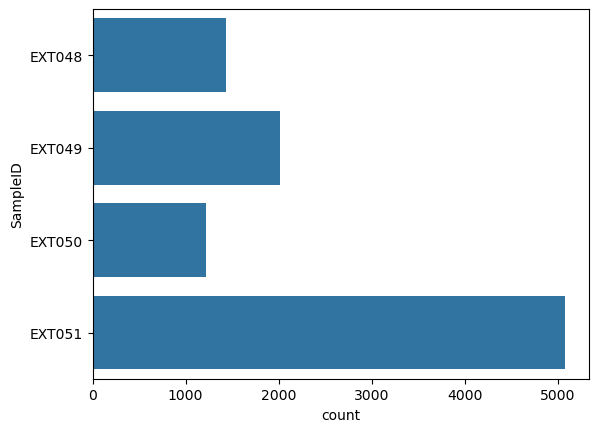

In [10]:
sns.countplot(data=adata.obs, y='SampleID')

In [18]:
sample_sheet = [
    ['EXT048', f'{DIR_data}/SC035/EXT048/outs/possorted_genome_bam.bam'],
    ['EXT049', f'{DIR_data}/SC035/EXT049/outs/possorted_genome_bam.bam'],
    ['EXT050', f'{DIR_data}/SC035/EXT050/outs/possorted_genome_bam.bam'],
    ['EXT051', f'{DIR_data}/SC035/EXT051/outs/possorted_genome_bam.bam'],
]
sample_sheet = pd.DataFrame(sample_sheet, )
sample_sheet.to_csv(f'{DIR_out}/sample_sheet.tsv', sep='\t', index=False, header=None)

# Step 1.

In [28]:
PATH_str_tsv            = '/home/18parkky/git/CRC_MSI_intensity_analysis/scripts/Revision1/GRCh38_Krait_1bp.genes.tsv'
PATH_reference_genome   = '/node200data/18parkky/datasets/reference/genome/GRCh38.p14_genomic.fa'
threads = 36
mapq_threshold              = 1
realignment_flanking_length = 50
flanking_length = 6
start_time = time.time()

In [29]:
import getAlleleTable

sample_sheet.columns = ['SampleID', 'PATH_bam']
merged_Allele_Table = list()

for tup in sample_sheet.itertuples():
    print(f'Running getAlleleTable for:\t{tup.SampleID}', flush=True)
    DIR_out_e = f'{DIR_out}/{tup.SampleID}'
    scMnT_utility.checkAndCreate(DIR_out_e)
    getAlleleTable.runGetAlleleTable( tup.PATH_bam, PATH_str_tsv, PATH_reference_genome, mapq_threshold, threads, flanking_length, realignment_flanking_length, start_time, tup.SampleID, DIR_out_e )
    Allele_Table_e = pd.read_csv(f'{DIR_out_e}/{tup.SampleID}.AlleleTable.tsv', sep='\t')
    Allele_Table_e['SampleID'] = tup.SampleID
    merged_Allele_Table.append( Allele_Table_e )

Running getAlleleTable for:	EXT048
Running getAlleleTable for:	EXT049
Running getAlleleTable for:	EXT050
Running getAlleleTable for:	EXT051


In [38]:
merged_Allele_Table = pd.concat(merged_Allele_Table)
merged_Allele_Table.reset_index(inplace=True, drop=True)
merged_Allele_Table.to_csv(f'merged_Allele_Table.tsv', sep='\t', index=False)

In [30]:
getAlleleTable.runGetAlleleTable( '/node200data/18parkky/datasets/data/public/processed_data/scMnT_speed_test/input/CRC2783/XHC078/outs/possorted_genome_bam.bam', 
                                 PATH_str_tsv, PATH_reference_genome, mapq_threshold, threads, flanking_length, realignment_flanking_length, start_time, 
                                 'XHC078', '/node200data/18parkky/datasets/data/public/processed_data/scMnT_speed_test/output/XHC078/scMnT' )

In [41]:
adata_CRC2783 = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_CRC2783 = adata_CRC2783[(adata_CRC2783.obs['PatientID']=='CRC2783')].copy()

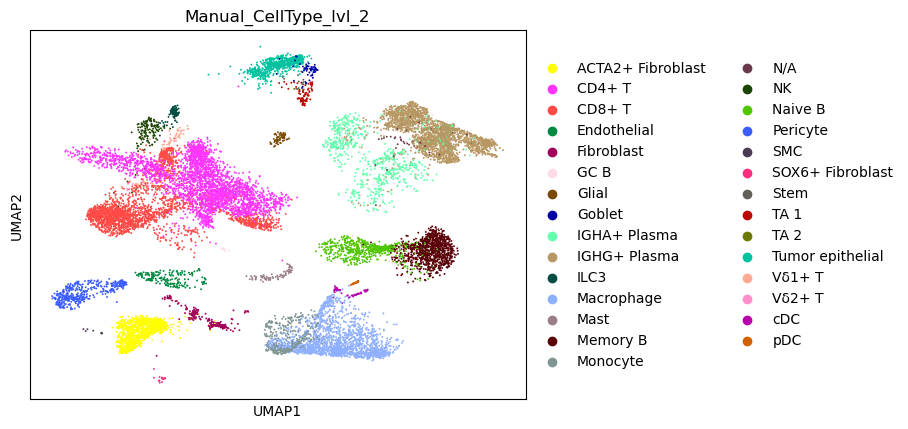

In [54]:
sc.pl.umap(adata_CRC2783, color=['Manual_CellType_lvl_2'])

In [56]:
dict_CellType_lvl_2_CellType = {
    'ACTA2+ Fibroblast' : 'Stromal',
    'CD4+ T' : 'T',
    'CD8+ T' : 'T',
    'Endothelial' : 'Stromal',
    'Fibroblast' : 'Stromal',
    'GC B' : 'B',
    'Glial' : 'Stromal',
    'Goblet' : 'Epithelial',
    'IGHA+ Plasma' : 'B',
    'IGHG+ Plasma' : 'B',
    'ILC3' : 'T',
    'Macrophage' : 'Myeloid',
    'Mast' : 'Myeloid',
    'Memory B' : 'B',
    'Monocyte' : 'Myeloid',
    'N/A' : 'N/A',
    'NK' : 'NK',
    'Naive B' : 'B',
    'Pericyte' : 'Stromal',
    'SMC' : 'Stromal',
    'SOX6+ Fibroblast' : 'Stromal',
    'Stem' : 'Epithelial',
    
    'TA 1' : 'Epithelial',
    'TA 2' : 'Epithelial',
    'Tumor epithelial' : 'Tumor epithelial',
    'cDC' : 'Myeloid',
    'pDC' : 'Myeloid',
}

adata_CRC2783.obs['CellType'] = [ dict_CellType_lvl_2_CellType.get(CT, 'T') for CT in adata_CRC2783.obs['Manual_CellType_lvl_2'] ]

In [62]:
adata_CRC2783.obs.drop(['AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI_score', 'MSI_score_z'], axis=1, inplace=True)

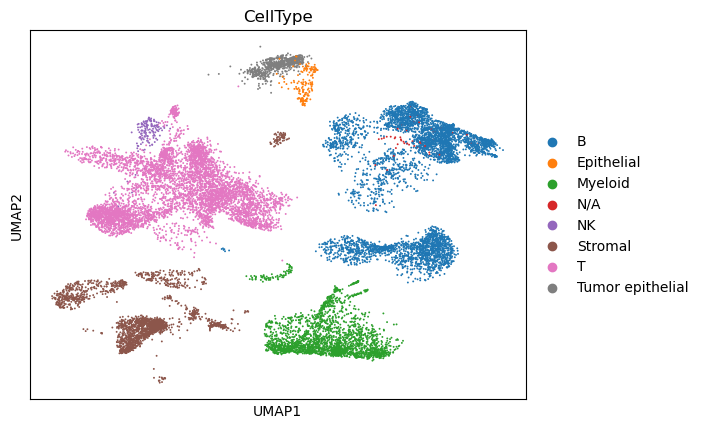

In [57]:
sc.pl.umap(adata_CRC2783, color='CellType')

In [63]:
adata_CRC2783.write(f'/node200data/18parkky/datasets/data/public/processed_data/scMnT_speed_test/input/CRC2783/adata.CellType_labeled.h5ad')

In [72]:
set(adata_CRC2783.obs['SampleID'])

{'XHC078', 'XHC079', 'XHC080', 'XHC081', 'XHC082', 'XHC083'}

In [73]:
grch38 = pd.read_csv('/home/18parkky/git/scMnT/ref/GRCh38-1bp_STR.tsv.gz', sep='\t')
grch38

,id,sequence,standard,motif,type,repeat,start,end,length,left_flanking_seq,right_flanking_seq,lf_2mer_complexity,rf_2mer_complexity
0,10,chr1,A,T,1,15,28589,28603,15,TAATAATGGTGG,GCATCTATGAAG,5.761905,9.307692
1,12,chr1,A,A,1,14,31720,31733,14,ACCCTGTCTCAG,GTACTTTGTAAT,7.117647,7.117647
2,13,chr1,A,A,1,15,33450,33464,15,TTCACCTCCATT,GGACCAGATGTG,6.368421,8.066667
3,14,chr1,A,T,1,11,33531,33541,11,AGTTTTTTTTTC,ATATACTTAAGT,1.805970,6.368421
4,16,chr1,A,A,1,13,36352,36364,13,TTTAAAGTTTGG,CCCAGCCTGGCG,4.840000,6.368421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014476,1633767,chrY,A,A,1,11,57188868,57188878,11,GGAGACTGTCTC,TTTGCTTAGAAT,7.117647,7.117647
1014477,1633775,chrY,A,A,1,14,57200838,57200851,14,TACTAAAAATAT,TTAGCCAGGCAT,3.903226,7.117647
1014478,1633776,chrY,A,A,1,20,57201000,57201019,20,AGACTCCGTTTC,GGAAAAAAGAAA,8.066667,2.200000
1014479,1633777,chrY,A,A,1,23,57202381,57202403,23,TACTAAAAATAC,TTAGCTGGGCGC,3.903226,6.368421


In [70]:
adata_obs = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/scMnT_speed_test/output/multiSample_script/ss/XHC078/XHC078_ss_test.scMnT.h5ad').obs
adata_obs = adata_obs[(adata_obs['NumSTRLoci']>=10)]
NormalCellTypes = [ CellType for CellType in set(adata_obs['CellType']) if CellType[:5] != 'Tumor' ]
NormalCellTypes

[]

In [48]:
set(adata_CRC2783.obs['Manual_CellType_lvl_1'])

{'B',
 'Dendritic',
 'Epithelial',
 'Fibroblast',
 'Glial',
 'Mast',
 'Monocyte/Macrophage',
 'NK',
 'Pericyte',
 'Plasma',
 'SMC',
 'Stromal',
 'T'}